# Pecs and Fat Segmentation - Paper

### Keras 2.0

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import SimpleITK as sitk
%matplotlib inline

In [2]:
from keras.models import Model, model_from_json
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Activation, Flatten
from keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy, mean_absolute_error, categorical_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, BaseLogger, Callback, EarlyStopping, TensorBoard, LambdaCallback, ReduceLROnPlateau
from keras import backend as K
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


-----------------------

# 1. Reading Data & Pre-processing

In [3]:
def read_ProjectData(folder, num_files, data_type, clean):
    # data_type = 0 --> CTSlice
    # data_type = 1 --> labels
    
    type_name = ''
    if data_type: type_name = 'lm_'
    
    clean_name = ''
    if clean: clean_name = '_clean'
    
    for i, num in enumerate(num_files):
        if i == 0:
            file_name = 'Cont_' + type_name + str(num) + clean_name + '.nrrd'
            image_nrrd = sitk.ReadImage(folder + file_name)
            data = sitk.GetArrayFromImage(image_nrrd)
        else:
            file_name = 'Cont_' + type_name + str(num) + clean_name + '.nrrd'
            image_nrrd = sitk.ReadImage(folder + file_name)
            data_aux = sitk.GetArrayFromImage(image_nrrd)
            data = np.concatenate((data, data_aux), axis = 0)
            
    return data

CTSlices Shape: 
(2904, 512, 512)
Labels Shape: 
(2904, 512, 512)


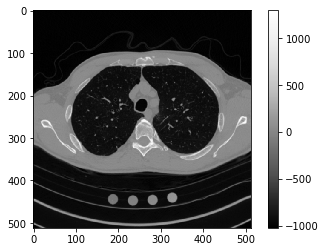

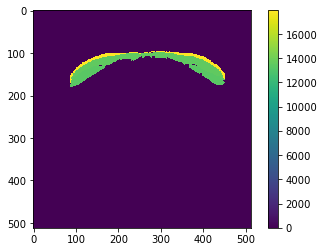

[    0 13335 13336 13591 13592 17943 17944]
(2904, 512, 512)


In [5]:
##-------------------------------------------------
## Reading Data
##-------------------------------------------------

folder = '/home/rmoreta/Projects/PectoralisSegmentation/Data/ProjectData_clean/'
num_files = [1,2] # from 1 to 7 nrrd files

# Reading CT
CTSlices = read_ProjectData(folder, num_files, 0, 1)
labels = read_ProjectData(folder, num_files, 1, 1)
        
print('CTSlices Shape: ')
print(CTSlices.shape)

print('Labels Shape: ')
print(labels.shape)

# num_labels = np.unique(labels)

# Image Representation
slice_num = 300
ToraxSlice = CTSlices[slice_num,:,:]
plt.figure()
plt.imshow(ToraxSlice,cmap='Greys_r')
plt.colorbar()
plt.show()

LabelToraxSlice = labels[slice_num,:,:]
plt.figure()
plt.imshow(LabelToraxSlice)
plt.colorbar()
plt.show()
print(np.unique(LabelToraxSlice))

##-------------------------------------------------
## Normalazing
##-------------------------------------------------

CTSlices_norm = CTSlices.astype(np.float32)
CTSlices_norm[CTSlices_norm < -1024] = -1024
CTSlices_norm[CTSlices_norm > 1500] = 1500
CTSlices_norm = (CTSlices_norm + 1024) / (1500 + 1024) - 0.5

print(CTSlices_norm.shape)

-------------

**Selecting Labels**

(2904, 512, 512, 5)


/home/rmoreta/anaconda2/envs/tensorflow_2/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


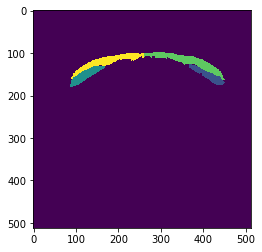

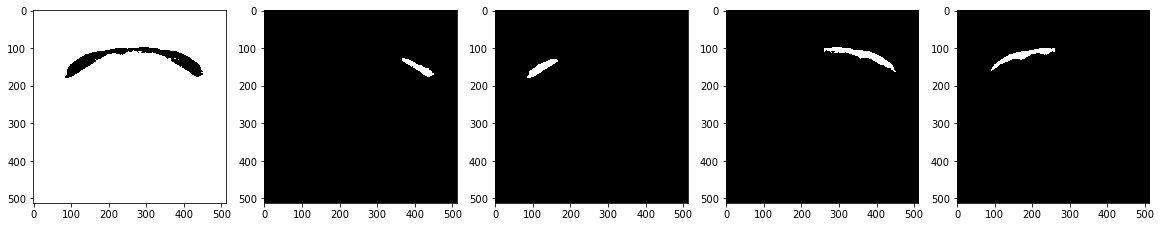

In [6]:
##-------------------------------------------------
## Selecting Labels
##-------------------------------------------------
labels = read_ProjectData(folder, num_files, 1, 1)

labels[(labels!=13335)&(labels!=13336)&(labels!=13591)&(labels!=13592)&(labels!=17943)&(labels!=17944)] = 0
labels[(labels==13335)] = 1 # Left Minor Pectoral
labels[(labels==13336)] = 2 # Right Minor Pectoral
labels[(labels==13591)] = 3 # Left Major Pectoral
labels[(labels==13592)] = 4 # RIght Major Pectoral
labels[(labels==17943)] = 0 # Left Fat 
labels[(labels==17944)] = 0 # Right Fat 
plt.figure()
plt.imshow(labels[slice_num,:,:])
np.unique(labels[slice_num,:,:])

num_classes = np.unique(labels[slice_num,:,:]).shape[0]

##-------------------------------------------------
## Transforming labels to categorical
##-------------------------------------------------

labels_cat = (np.arange(num_classes) == labels[:,:,:,None])
print(labels_cat.shape)

f, a = plt.subplots(1, num_classes, figsize=(20, 20))
for i in range(num_classes):
    a[i].imshow(labels_cat[slice_num,:,:,i],cmap='Greys_r')
f.show()
plt.draw()

---------

## Spliting data in Training And Testing

In [7]:
CTSlices_norm.shape

(2904, 512, 512)

In [8]:
img_rows = CTSlices_norm.shape[1]
img_cols = CTSlices_norm.shape[2]

num_images_train = 1500
num_images_val = 600
num_images_test = 600

train_dataset = CTSlices_norm[0 : num_images_train,:,:]
train_labels = labels_cat[0 : num_images_train,:,:]

val_dataset = CTSlices_norm[num_images_train : num_images_train+num_images_val,:,:]
val_labels = labels_cat[num_images_train : num_images_train+num_images_val,:,:]

test_dataset = CTSlices_norm[num_images_train+num_images_val : num_images_train+num_images_val+num_images_test,:,:]
test_labels = labels_cat[num_images_train+num_images_val : num_images_train+num_images_val+num_images_test,:,:]

print(train_dataset.shape)
print(train_labels.shape)
print(val_dataset.shape)
print(val_labels.shape)
print(test_dataset.shape)
print(test_labels.shape)

(1500, 512, 512)
(1500, 512, 512, 5)
(600, 512, 512)
(600, 512, 512, 5)
(600, 512, 512)
(600, 512, 512, 5)


In [9]:
imgs_train = np.reshape(train_dataset,(num_images_train, img_rows, img_cols, 1))
imgs_mask_train = np.reshape(train_labels,(num_images_train, img_rows, img_cols, num_classes))

print('Taining Shape:', imgs_train.shape)
print('Training Mask Shape:', imgs_mask_train.shape)

imgs_val = np.reshape(val_dataset,(num_images_val, img_rows, img_cols, 1))
imgs_mask_val = np.reshape(val_labels,(num_images_val, img_rows, img_cols, num_classes))

print('Validation Shape: ', imgs_val.shape)
print('Validation Mask Shape: ', imgs_mask_val.shape)

imgs_test = np.reshape(test_dataset,(num_images_test, img_rows, img_cols, 1))
imgs_mask_test = np.reshape(test_labels,(num_images_test, img_rows, img_cols, num_classes))

print('Test Shape: ', imgs_test.shape)
print('Test Mask Shape: ', imgs_mask_test.shape)

('Taining Shape:', (1500, 512, 512, 1))
('Training Mask Shape:', (1500, 512, 512, 5))
('Validation Shape: ', (600, 512, 512, 1))
('Validation Mask Shape: ', (600, 512, 512, 5))
('Test Shape: ', (600, 512, 512, 1))
('Test Mask Shape: ', (600, 512, 512, 5))


-----------

-----------

## Architecture Initialization


In [10]:
def IoU(y_true, y_pred):

    y_true = K.round(K.clip(y_true, 0, 1))
    y_pred = K.round(K.clip(y_pred, 0, 1))
    
    tp = K.sum(K.sum(K.sum((y_true * y_pred), axis=2),axis=1),axis=0)  
    fn = K.sum(K.sum(K.sum(((y_true + y_pred)*y_true), axis=2),axis=1),axis=0) - tp*2.
    fp = K.sum(K.sum(K.sum(((y_true + y_pred)*y_pred), axis=2),axis=1),axis=0) - tp*2.
    
    IoU = K.mean((tp)/(tp + fn + fp))
    
    return IoU

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)

In [14]:
def unet_downblock(x, filters, kernel_size, bn, block):
    """
    # Arguments
    
    # Returns
    
    """
    conv_name = 'block' + str(block) + '_conv'
    bn_name = 'block' + str(block) + '_bn'
    pool_name = 'block' + str(block) + '_bn'
    activ_name = 'block' + str(block) + '_activation'
    
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    
    
    x = Conv2D(filters, kernel_size, padding="same", name=conv_name+'1')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name+'1')(x) if bn else x
    x = Activation('relu', name=activ_name+'1')(x)
    
    x = Conv2D(filters, kernel_size, padding="same", name=conv_name+'2')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name+'2')(x) if bn else x
    x = Activation('relu', name=activ_name+'2')(x)
    
    pool = MaxPooling2D(pool_size=(2, 2), name=pool_name)(x)
    
    return pool, x



def unet_upblock(x, conv_down, filters, kernel_size, bn, block):
    """
    # Arguments
    
    # Returns
    
    """
    conv_name = 'block' + str(block) + '_conv'
    bn_name = 'block' + str(block) + '_bn'
    pool_name = 'block' + str(block) + '_bn'
    activ_name = 'block' + str(block) + '_activation'
    
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
        
    
    up = UpSampling2D(size=(2, 2))(x)
    conv_up = Conv2D(filters, (2, 2),  padding="same", activation="relu", name=conv_name + 'Up')(up)
    concat = concatenate([conv_up, conv_down], axis=3, name='block'+str(block)+'_conc')
    
    x = Conv2D(filters, kernel_size, padding="same", name=conv_name+'1')(concat)
    x = BatchNormalization(axis=bn_axis, name=bn_name+'1')(x) if bn else x
    x = Activation('relu', name=activ_name+'1')(x)
    
    x = Conv2D(filters, kernel_size, padding="same", name=conv_name + '2')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name+'2')(x) if bn else x
    x = Activation('relu', name=activ_name+'2')(x)
    
    return x



def unet(input_shape, num_classes):
    """
    # Arguments
    
    # Returns
    
    """
    
    kernel_size = (3,3)
    filters_init = 32
    bn = 0
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    
    
    inputs = Input(shape=input_shape)
    
    poolBlock1, convBlock1 = unet_downblock(inputs, filters_init, kernel_size, bn, block=1)
    
    poolBlock2, convBlock2 = unet_downblock(poolBlock1, filters_init*2, kernel_size, bn, block=2)
    
    poolBlock3, convBlock3 = unet_downblock(poolBlock2, filters_init*4, kernel_size, bn, block=3)
    
    poolBlock4, convBlock4 = unet_downblock(poolBlock3, filters_init*8, kernel_size, bn, block=4)
    
    
    convBlock5 = Conv2D(filters_init*16, (3, 3), padding="same", name='block5_conv1')(poolBlock4)
    convBlock5 = BatchNormalization(axis=bn_axis, name='block5_bn1')(convBlock5) if bn else convBlock5
    convBlock5 = Activation('relu', name='block5_activation1')(convBlock5)
    convBlock5 = Conv2D(filters_init*16, (3, 3), padding="same", name='block5_conv2')(convBlock5)
    convBlock5 = BatchNormalization(axis=bn_axis, name='block5_bn2')(convBlock5) if bn else convBlock5
    convBlock5 = Activation('relu', name='block5_activation2')(convBlock5)
    
    
    convBlock6 = unet_upblock(convBlock5, convBlock4, filters_init*8, kernel_size, bn, block=6)
    
    convBlock7 = unet_upblock(convBlock6, convBlock3, filters_init*4, kernel_size, bn, block=7)
    
    convBlock8 = unet_upblock(convBlock7, convBlock2, filters_init*2, kernel_size, bn, block=8)
    
    convBlock9 = unet_upblock(convBlock8, convBlock1, filters_init, kernel_size, bn, block=9)
    
    
    convBlock10 = Conv2D(num_classes, (1, 1), activation='sigmoid', name='block10_conv')(convBlock9)
    
    model = Model(outputs=[convBlock10], inputs=inputs, name='u-net')
    
    return model

----------

In [15]:
from keras.models import Model, model_from_json
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Activation, Flatten
from keras.layers.merge import concatenate
from keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy, mean_absolute_error, categorical_crossentropy, mean_squared_error
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, BaseLogger, Callback, EarlyStopping, TensorBoard, LambdaCallback, ReduceLROnPlateau
from keras import backend as K
from keras.utils.np_utils import to_categorical

In [24]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.train_losses = []
        self.val_losses = []
        self.train_acc = []
        self.val_acc = []
        self.lr = []
#         self.IoU = []
#         self.dice_coef = []

    def on_batch_end(self, batch, logs={}):
        pass
        
    
    def on_epoch_end(self, epoch, logs={}):
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        self.train_losses.append(logs.get('loss'))
        self.train_acc.append(logs.get('acc'))
        self.lr.append(logs.get('lr'))
        
history = LossHistory()

# Save model in .hdf5
path_unet = '/home/rmoreta/Projects/PectoralisSegmentation/Results/'
name_unet = 'unet_nc' + str(num_classes) + '_pecs_' + str(num_images_train) + 'prueba_k2' + '.hdf5'
model_checkpoint = ModelCheckpoint(path_unet + name_unet, monitor='loss',verbose=1, save_best_only=True)

# Create a CVS with the values of loss and accuracy at each epoch
model_CSVLogger = CSVLogger('hola.cvs', separator=',', append=True)

# Gets loss values at each batch and epoch in a list
history = LossHistory()

# Early Stopping 
model_EarlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto')

# Reduce LR
model_ReduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', 
                  cooldown=0, min_lr=0.000001) # epsilon=0.0001


In [17]:
input_shape = (img_rows, img_cols, 1)
model = unet(input_shape, num_classes)

In [ ]:
path_results = '/home/rmoreta/Projects/Biometria/Results/general/'
plot_model(model, to_file=path_results+'model_BiometryNet5.png', show_shapes=True, show_layer_names=True)
plot_model(model_conv, to_file=path_results+'model_BiometryNet5_model_conv.png', show_shapes=True, show_layer_names=True)ñ

In [ ]:
model.summary()

#### Training

In [18]:
w_init = model.get_weights()
path_unet_w = '/home/rmoreta/Projects/PectoralisSegmentation/Results/Unets/final/'
unet_name = 'unet_nc5_pecs.hdf5'
model.load_weights(path_unet_w + unet_name)
w_2 = model.get_weights()

In [ ]:
model.compile(optimizer=Adam(lr=0.0001), loss=categorical_crossentropy, metrics=['accuracy', IoU, dice_coef])

In [25]:
np.random.seed(9754)

model.compile(optimizer=Adam(lr=0.0001), loss=categorical_crossentropy, metrics=['accuracy', IoU, dice_coef])

batch_size = 8
nb_epoch = 1

hist = model.fit(imgs_train, imgs_mask_train, 
                 validation_data = (imgs_val, imgs_mask_val), 
                 batch_size=batch_size, 
                 epochs=nb_epoch,
                 verbose=1, shuffle=True,
                 callbacks=[history, model_CSVLogger, model_EarlyStopping, model_ReduceLROnPlateau])
                 #callbacks=[history, model_CSVLogger, model_EarlyStopping, model_ReduceLROnPlateau])

Train on 1500 samples, validate on 600 samples
Epoch 1/1
1500/1500 [==============================] - 147s - loss: 0.0082 - acc: 0.9968 - IoU: 0.8977 - dice_coef: 0.9973 - val_loss: 0.0106 - val_acc: 0.9963 - val_IoU: 0.8815 - val_dice_coef: 0.9969

In [27]:
history.lr

[None]

AttributeError: 'LossHistory' object has no attribute 'val_accuracy'

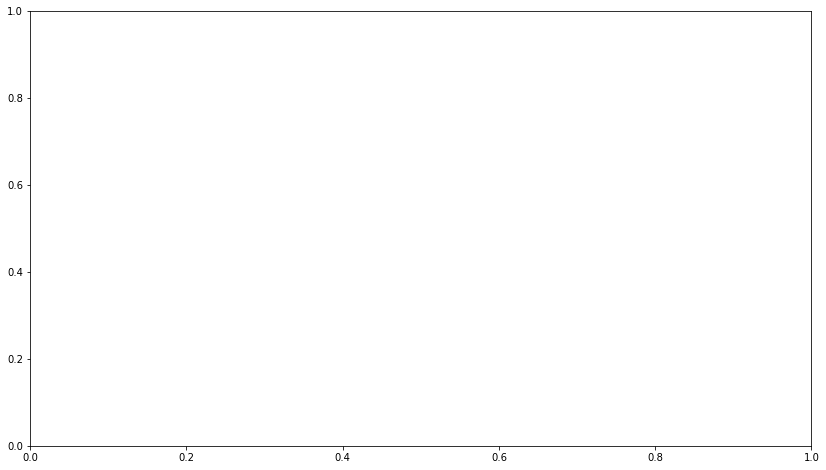

In [28]:
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(111)
ax1.plot(range(nb_epoch), history.val_accuracy, color = 'b', lw = '2.0')
ax1.plot(range(nb_epoch), history.accuracy, color = 'r', lw = '2.0')
ax1.set_title('Validation Accuracy Vs Epochs\n', fontsize=15);
ax1.set_xlabel('\n # Epoch',fontsize=30, fontweight = 'bold')
ax1.set_ylabel('\n Validation Accuracy (%)',fontsize=30, fontweight = 'bold')
#ax.set_xlim(0, 26)
#ax.set_ylim(-0.25, 90)
#plt.xticks(range(0, 25, 1), fontsize=14)
#plt.yticks(range(0, 91, 10), fontsize=14)
plt.draw()

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(111)
ax1.plot(range(nb_epoch), history.val_losses, color = 'b', lw = '2.0')
ax1.plot(range(nb_epoch), history.losses, color = 'r', lw = '2.0')
ax1.set_title('Validation Loss Vs Epochs\n', fontsize=15);
ax1.set_xlabel('\n # Epoch',fontsize=30, fontweight = 'bold')
ax1.set_ylabel('\n Validation Loss',fontsize=30, fontweight = 'bold')
plt.draw()

** Testing **

In [ ]:
# Test Prediction
print('Test Prediction')
imgs_mask_pred = model.predict(imgs_test, verbose=1)

# Test
print('Test Evaluation')
test_evaluation = model.evaluate(imgs_test, imgs_mask_test, verbose=1)

# Saving prediction results
#np.save('imgs_mask_pred_test.npy', imgs_mask_pred)

print('Test loss:', test_evaluation[0])
print('Test accuracy:', test_evaluation[1])

In [ ]:
for i in [0]:
    f, a = plt.subplots(1, num_classes, figsize=(10, 10))
    f2, a2 = plt.subplots(1, num_classes, figsize=(10, 10))
    a[1].imshow(imgs_mask_test[i,:,:,1], cmap='Greys_r')
    a[2].imshow(imgs_mask_test[i,:,:,2], cmap='Greys_r')
    a[0].imshow(imgs_test[i,:,:,0], cmap='Greys_r')
    a2[0].imshow(imgs_mask_pred[i,:,:,0], cmap='Greys_r')
    a2[1].imshow(imgs_mask_pred[i,:,:,1], cmap='Greys_r')
    a2[2].imshow(imgs_mask_pred[i,:,:,2], cmap='Greys_r')
    f.show()
    f2.show()
    plt.draw()